# Semestrální projekt, Využití Umělých Neuronových Sítí při kompresi dat
- Student: Petr Ptáček, PTA0054
- Vedoucí práce: Ing. Michal Vašinek Ph.D.

## Dataset Gutenberg
- Data se skládají z 89 textových souborů, které dohromady tvoří knihu.
- Těchto 89 souborů jsem si rozdělil v poměru 80 : 20 na trénovací a testovací sady.

## Importy knihoven

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import time
import string
import random
import sys

# Pandas dataframes
import pandas as pd
# Numpy
import numpy as np 
# Tensorflow 2.10.0
import tensorflow as tf
from tensorflow.keras.utils import Sequence


# scikit-learn
import sklearn
from sklearn.model_selection import train_test_split

# Graphing
import matplotlib
from matplotlib import pyplot as plt

# Packages for manipulation with images
from PIL import Image

#
import functools

In [2]:
# check if gpu is ready to use
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.sysconfig.get_build_info() 

OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.2'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [4]:
# Set logging level only to ERROR
tf.get_logger().setLevel("ERROR")

## Funkce

In [5]:
# Load alphabet of all files which meet the pattern.
"""
def load_alphabet(pattern: str) -> set():
     # list files in folder
    filenames = tf.data.Dataset.list_files(pattern,)
    alphabet = set()
    # For each file in folder
    for filename in filenames:
        # read whole file
        with open(filename.numpy(), mode="r", encoding="ISO-8859-1") as file:
            text = file.read()
             # insert the list to the set
            alphabet = alphabet.union(set(text))
            del text

    return alphabet
"""

'\ndef load_alphabet(pattern: str) -> set():\n     # list files in folder\n    filenames = tf.data.Dataset.list_files(pattern,)\n    alphabet = set()\n    # For each file in folder\n    for filename in filenames:\n        # read whole file\n        with open(filename.numpy(), mode="r", encoding="ISO-8859-1") as file:\n            text = file.read()\n             # insert the list to the set\n            alphabet = alphabet.union(set(text))\n            del text\n\n    return alphabet\n'

In [5]:
def load_data_binary(pattern: str, shuffle: bool = False, seed:int = None, lengthOfSubstring: int = 3, portion: float = 0.5) -> ([],[]):
    train_x = []
    train_y = []
    
    # Get list of filenames from pattern
    filenames = tf.data.Dataset.list_files(pattern, shuffle=shuffle, seed=seed)
    filenames = [i.numpy() for i in filenames]
    filenames = random.sample(filenames, int(len(filenames) * portion))
    #print(filenames)
    # Set initial file_index and position in file.
    position_in_file = 0
    file_index = 0
    
    print(f'Loading gutenberg dataset [{round( (file_index) / len(filenames) * 100, 1)} %]\r', end="")
    # File Loop
    while file_index < len(filenames):
        # Open File
        with open(filenames[file_index], mode="rb") as file:
            file.seek(position_in_file)
            byte_x = [file.read(1) for i in range(0, lengthOfSubstring)] #file.read(lengthOfSubstring)
            byte_y = [file.read(1)]
            # Main read loop
            while True:
                # If end of file
                if b'' in byte_x or b'' in byte_y:
                    file_index += 1
                    position_in_file = 0
                    break
                else:
                    train_x.append(byte_x)
                    train_y.append(byte_y)
                    # Read like this: "Hello world!" -> ("Hel","l"), ("ell","o"), ("llo"," "), ...
                    position_in_file += 1
                    file.seek(position_in_file)
                    byte_x = [file.read(1) for i in range(0, lengthOfSubstring)] #file.read(lengthOfSubstring)
                    byte_y = [file.read(1)]
        print(f'Loading gutenberg dataset [{round( (file_index) / len(filenames) * 100, 1)} %]\r', end="")
                    
    return train_x, train_y



In [7]:
# Deprecated
# Load data from files into train_x and train_y np arrays in format "tex" -> "t", "ext" -> "u", "xtu" -> "r", "tur" -> "e", ... 
"""
def load_data(pattern: str, shuffle: bool = False, seed:int = None, lengthOfSubstring: int = 3, removeDuplicates:bool = False) -> ([],[]):
    # list files in folder
    filenames = tf.data.Dataset.list_files(pattern, shuffle=shuffle, seed=seed)
    data = []
    # For each file in folder
    for filename in filenames:
        # read whole file
        with open(filename.numpy(), mode="r", encoding="ISO-8859-1") as file:
            #print(filename.numpy())
            text = file.read()

            for i in range(0, len(text)-lengthOfSubstring):
                #index = np.random.randint(low=0, high=len(text))
                index = i
                x = text[index:index + lengthOfSubstring]
                y = text[index + lengthOfSubstring]
                
                data.append((x, y))
            del text
        # Remove duplicates
        if removeDuplicates:
            data = list(dict.fromkeys(data))
    
    data_x = [x[0] for x in data]
    data_y = [x[1] for x in data]
    del data
    return np.array(data_x), np.array(data_y)
"""

'\ndef load_data(pattern: str, shuffle: bool = False, seed:int = None, lengthOfSubstring: int = 3, removeDuplicates:bool = False) -> ([],[]):\n    # list files in folder\n    filenames = tf.data.Dataset.list_files(pattern, shuffle=shuffle, seed=seed)\n    data = []\n    # For each file in folder\n    for filename in filenames:\n        # read whole file\n        with open(filename.numpy(), mode="r", encoding="ISO-8859-1") as file:\n            #print(filename.numpy())\n            text = file.read()\n\n            for i in range(0, len(text)-lengthOfSubstring):\n                #index = np.random.randint(low=0, high=len(text))\n                index = i\n                x = text[index:index + lengthOfSubstring]\n                y = text[index + lengthOfSubstring]\n                \n                data.append((x, y))\n            del text\n        # Remove duplicates\n        if removeDuplicates:\n            data = list(dict.fromkeys(data))\n    \n    data_x = [x[0] for x in data]\n  

In [8]:
# String vectorizer function which hot encode each character into vector of 0/1 of size of alphabete
"""
def string_vectorizer(strng: str, alphabet: set() =string.ascii_lowercase) -> [[int]]:
    vector = [[0 if char != letter else 1 for char in alphabet] for letter in strng]
    return vector
"""

'\ndef string_vectorizer(strng: str, alphabet: set() =string.ascii_lowercase) -> [[int]]:\n    vector = [[0 if char != letter else 1 for char in alphabet] for letter in strng]\n    return vector\n'

In [6]:
def get_alphabet(data_x, data_y):
    alp = set()
    for y in data_y:
        for _y in y:
            alp.add(_y)
    for x in data_x:
        for _x in x:
            alp.add(_x)
    return alp

In [66]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

## Třídy

In [51]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # From bytes to Int in range <0, 255>
        batch_x = np.array([[int.from_bytes(x, "big") for x in batch_x[i]] for i in range(0, len(batch_x))])
        batch_y = np.array([[int.from_bytes(y, "big") for y in batch_y[i]] for i in range(0, len(batch_y))])
        
        # From integers to vectors of size 256, one hot encoding
        batch_x = np.array([tf.keras.utils.to_categorical(x, num_classes=256) for x in batch_x])
        batch_y = np.array([tf.keras.utils.to_categorical(y, num_classes=256) for y in batch_y])
        
        # Return sizes are (batch_size, 3, 256), (batch_size, 1, 256)
        return batch_x, batch_y

## Načtení a zpracování dat

In [11]:
# load alphabet of gutenberg dataset
#start_time = time.time()
#alphabet = load_alphabet("./data/gutenberg/train/*.txt",)
#alphabet = alphabet.union(load_alphabet("./data/gutenberg/test/*.txt",))
#print("--- %s seconds ---" % (time.time() - start_time))

In [12]:
# Size of alphabet
#print(f"Size of alphabet of gutenberg dataset: {len(alphabet)}")

In [13]:
# Load train_x and train_y
#start_time = time.time()
#train_x, train_y = load_data("./data/gutenberg/train/*.txt", seed=42, removeDuplicates=True)
#print("--- %s seconds ---" % (time.time() - start_time))

In [19]:
del train_x
del train_y
del test_x
del test_y
del val_x
del val_y

In [20]:
# Load test_x and test_y in bytes
test_x, test_y = load_data_binary("./data/gutenberg/test/*-0.txt", seed=42, lengthOfSubstring=3, portion=0.3)
test_x = np.array(test_x)
test_y = np.array(test_y)
print(f"\nSize of test dataset: {len(test_y)} [{sys.getsizeof(test_x) + sys.getsizeof(test_y)} B]")

Loading gutenberg dataset [100.0 %]
Size of test dataset: 3351254 [13405272 B]


In [21]:
# Load train_x and train_y in bytes
train_x, train_y = load_data_binary("./data/gutenberg/train/*-0.txt", seed=42, lengthOfSubstring=3, portion=0.5)
train_x = np.array(train_x)
train_y = np.array(train_y)
print(f"\nSize of train dataset: {len(train_y)} [{sys.getsizeof(train_x) + sys.getsizeof(train_y)} B]")

Loading gutenberg dataset [100.0 %]
Size of train dataset: 22166977 [88668164 B]


In [22]:
# Split train set into - train and validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [23]:
print(f"Train data: {round(len(train_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Validation data: {round(len(val_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Test data: {round(len(test_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")

Train data: 69.49 %
Validation data: 17.37 %
Test data: 13.13 %


In [24]:
alphabet_train = get_alphabet(train_x, train_y)

In [25]:
alphabet_test = get_alphabet(test_x, test_y)

In [26]:
len(alphabet_train), len(alphabet_test)

(161, 115)

In [27]:
alphabet = alphabet_test.union(alphabet_train)
len(alphabet)

161

In [26]:
int.from_bytes(b'\xbb', "big")

187

In [ ]:
train_x = [[int.from_bytes(x, "big") for x in train_x[i]] for i in range(0, len(train_x))]

In [ ]:
for i, _ in enumerate(train_x):
    train_x[i] = [int.from_bytes(x, "big") for x in train_x[i]]
    train_y[i] = [int.from_bytes(x, "big") for x in train_x[i]]
    for j, _ in enumerate(train_x[i]):
        

In [32]:
tf.keras.utils.to_categorical([1,123,156], num_classes=256)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [20]:
alphabet

{b'\t',
 b'\n',
 b'\r',
 b' ',
 b'!',
 b'"',
 b'#',
 b'$',
 b'%',
 b'&',
 b"'",
 b'(',
 b')',
 b'*',
 b'+',
 b',',
 b'-',
 b'.',
 b'/',
 b'0',
 b'1',
 b'2',
 b'3',
 b'4',
 b'5',
 b'6',
 b'7',
 b'8',
 b'9',
 b':',
 b';',
 b'<',
 b'=',
 b'>',
 b'?',
 b'@',
 b'A',
 b'B',
 b'C',
 b'D',
 b'E',
 b'F',
 b'G',
 b'H',
 b'I',
 b'J',
 b'K',
 b'L',
 b'M',
 b'N',
 b'O',
 b'P',
 b'Q',
 b'R',
 b'S',
 b'T',
 b'U',
 b'V',
 b'W',
 b'X',
 b'Y',
 b'Z',
 b'[',
 b'\\',
 b']',
 b'^',
 b'_',
 b'`',
 b'a',
 b'b',
 b'c',
 b'd',
 b'e',
 b'f',
 b'g',
 b'h',
 b'i',
 b'j',
 b'k',
 b'l',
 b'm',
 b'n',
 b'o',
 b'p',
 b'q',
 b'r',
 b's',
 b't',
 b'u',
 b'v',
 b'w',
 b'x',
 b'y',
 b'z',
 b'{',
 b'|',
 b'}',
 b'~',
 b'\x80',
 b'\x81',
 b'\x82',
 b'\x83',
 b'\x84',
 b'\x86',
 b'\x88',
 b'\x89',
 b'\x8e',
 b'\x8f',
 b'\x91',
 b'\x92',
 b'\x93',
 b'\x94',
 b'\x95',
 b'\x97',
 b'\x98',
 b'\x99',
 b'\x9a',
 b'\x9c',
 b'\x9d',
 b'\xa0',
 b'\xa1',
 b'\xa2',
 b'\xa3',
 b'\xa4',
 b'\xa6',
 b'\xa7',
 b'\xa8',
 b'\xa9',
 b'\xaa',


In [ ]:
# Take a look at data
for i, _ in enumerate(train_x):
    print(f"{train_x[i]} -> {train_y[i]}")
    if i == 50:
        break

In [28]:
# Preprocess data, Vectorize characters using one hot encoding
train_x = np.array([string_vectorizer(x, alphabet) for x in train_x])
train_y = np.array([string_vectorizer(x, alphabet) for x in train_y])

In [30]:
train_y = train_y.reshape((train_y.shape[0], len(alphabet)))
val_y = val_y.reshape((val_y.shape[0], len(alphabet)))

In [31]:
train_x = train_x.reshape((train_x.shape[0], len(alphabet) * 3))
val_x = val_x.reshape((val_x.shape[0], len(alphabet) * 3))

In [32]:
# Size of train and validation datasets
print(f"Train set size (X, y): {train_x.shape}, {train_y.shape}")
print(f"Validation set size (X, y): {val_x.shape}, {val_y.shape}")

Train set size (X, y): (210756, 498), (210756, 166)
Validation set size (X, y): (52690, 498), (52690, 166)


## Dense ANN


In [53]:
# Input shape
inputShape = (3, 256)

In [64]:
# Create model of dense ANN
input_layer = tf.keras.Input(shape=inputShape)

flatten_layer1 = tf.keras.layers.Flatten()(input_layer)

dense_layer1 = tf.keras.layers.Dense(512, activation="relu")(flatten_layer1)
dense_layer1 = tf.keras.layers.Dropout(0.2)(dense_layer1)

dense_layer2 = tf.keras.layers.Dense(128, activation="relu")(dense_layer1)
dense_layer2 = tf.keras.layers.Dropout(0.2)(dense_layer2)

output_layer = tf.keras.layers.Dense(256, activation="softmax",)(dense_layer2)
output_layer = tf.keras.layers.Reshape((1, 256))(output_layer)

# Create model
dense_model = tf.keras.Model(input_layer, output_layer)


In [65]:
# Compile model
# Optimizer - RMSprop
# Loss - Binary Crossentropy
# Metric - Binary Accuracy
dense_model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])

dense_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3, 256)]          0         
                                                                 
 flatten_4 (Flatten)         (None, 768)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               393728    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               3302

In [67]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_dense_model.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size)
val_gen = DataGenerator(val_x, val_y, batch_size)


# Fit model.
history_dense_model = dense_model.fit(train_gen, validation_data=val_gen, epochs=epochs)

Epoch 1/10
138544/138544 [==============================] - 1071s 8ms/step - loss: 1.7861 - categorical_accuracy: 0.4707 - val_loss: 1.6839 - val_categorical_accuracy: 0.4884
Epoch 2/10
138544/138544 [==============================] - 1067s 8ms/step - loss: 1.7435 - categorical_accuracy: 0.4786 - val_loss: 1.6748 - val_categorical_accuracy: 0.4904
Epoch 3/10
138544/138544 [==============================] - 1078s 8ms/step - loss: 1.7391 - categorical_accuracy: 0.4796 - val_loss: 1.6728 - val_categorical_accuracy: 0.4889
Epoch 4/10
138544/138544 [==============================] - 1083s 8ms/step - loss: 1.7385 - categorical_accuracy: 0.4799 - val_loss: 1.6710 - val_categorical_accuracy: 0.4912
Epoch 5/10
138544/138544 [==============================] - 1081s 8ms/step - loss: 1.7391 - categorical_accuracy: 0.4800 - val_loss: 1.6725 - val_categorical_accuracy: 0.4910
Epoch 6/10
138544/138544 [==============================] - 1090s 8ms/step - loss: 1.7401 - categorical_accuracy: 0.4799 - va

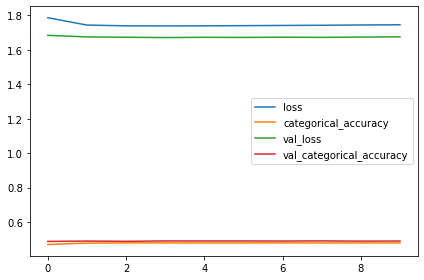

In [68]:
show_history(history_dense_model)

In [70]:
# Save trained weights and biases.
dense_model.save('models/model_dense')

## Recurrent ANN

In [73]:
# Create model of recurent ANN
input_layer = tf.keras.Input(shape=inputShape)

lstm_layer1 = tf.keras.layers.LSTM(64, activation="relu", return_sequences=True)(input_layer)

gru_layer1 = tf.keras.layers.GRU(64, activation="relu", return_sequences=True)(lstm_layer1)

flatten_layer1 = tf.keras.layers.Flatten()(gru_layer1)

dense_layer1 = tf.keras.layers.Dense(512, activation="relu")(flatten_layer1)

dense_layer2 = tf.keras.layers.Dense(256, activation="relu")(dense_layer1)
dense_layer2 = tf.keras.layers.Dropout(0.3)(dense_layer2)

output_layer = tf.keras.layers.Dense(256, activation="softmax",)(dense_layer2)
output_layer = tf.keras.layers.Reshape((1, 256))(output_layer)

# Create model
recurrent_model = tf.keras.Model(input_layer, output_layer)


In [74]:
# Compile model
# Optimizer - RMSprop
# Loss - Binary Crossentropy
# Metric - Binary Accuracy
recurrent_model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                        metrics=[tf.keras.metrics.CategoricalAccuracy()])

recurrent_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 256)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             82176     
                                                                 
 gru_1 (GRU)                 (None, 3, 64)             24960     
                                                                 
 flatten_6 (Flatten)         (None, 192)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               98816     
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0   

In [ ]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_recurrent_model.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 1024
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size)
val_gen = DataGenerator(val_x, val_y, batch_size)


# Fit model.
history_recurrent_model = recurrent_model.fit(train_gen, validation_data=val_gen, epochs=epochs)

Epoch 1/10
17318/17318 [==============================] - 964s 56ms/step - loss: 1.8066 - categorical_accuracy: 0.4697 - val_loss: 1.7239 - val_categorical_accuracy: 0.4861
Epoch 2/10
17318/17318 [==============================] - 1101s 64ms/step - loss: 1.8023 - categorical_accuracy: 0.4725 - val_loss: 1.7616 - val_categorical_accuracy: 0.4760
Epoch 3/10
17318/17318 [==============================] - 1103s 64ms/step - loss: 1.8680 - categorical_accuracy: 0.4606 - val_loss: 1.8465 - val_categorical_accuracy: 0.4703
Epoch 4/10
17318/17318 [==============================] - 989s 57ms/step - loss: 1.9218 - categorical_accuracy: 0.4516 - val_loss: 1.8682 - val_categorical_accuracy: 0.4594
Epoch 5/10
17318/17318 [==============================] - 1008s 58ms/step - loss: 1.9845 - categorical_accuracy: 0.4408 - val_loss: 1.9245 - val_categorical_accuracy: 0.4521
Epoch 6/10
  760/17318 [>.............................] - ETA: 12:45 - loss: 2.0212 - categorical_accuracy: 0.4347

In [ ]:
show_history(history_recurrent_model)

In [ ]:
# Save trained weights and biases.
recurrent_model.save('models/model_recurrent')